In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install tqdm

In [2]:
import logging
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

In [3]:
logger = logging.getLogger("notebooks")
logging.basicConfig(level=logging.INFO)

In [4]:
class MABEnv:
    def __init__(self, num_actions: int, reward_mean = 0, reward_scale = 1):
        self.num_actions = num_actions
        self.reward_mean = reward_mean
        self.reward_scale = reward_scale
        self.actions = np.ndarray(num_actions)
        self.rewards = np.random.normal(loc=self.reward_mean, scale=self.reward_scale, size=self.num_actions)
        
    def reset(self):
        self.timestep = 0

    def update(self):
        self.timestep += 1

    def get_timestep(self):
        return self.timestep

    def get_actions(self) -> np.ndarray:
        return self.actions

    def get_rewards(self) -> np.ndarray:
        return self.rewards

    def perform_action(self, action_id: int, size=1) -> float:
        return np.random.normal(loc=self.rewards[action_id], scale=1, size=size)[0]

In [5]:
class BaseEstimator:
    def reset(self):
        pass

    def learn_reward(self, action_id: int, reward: float) -> None:
        pass

In [6]:
class DummyEstimator(BaseEstimator):
    def __init__(self, env):
        self.reward_estimates = np.full_like(env.get_actions(), fill_value=1)

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

In [7]:
class OracleEstimator(BaseEstimator):
    def __init__(self, env):
        self.env = env
   
    def get_rewards(self) -> np.ndarray:
        return self.env.get_rewards()

In [8]:
class RunningMeanEstimator(BaseEstimator):
    def __init__(self, env, prior: float = 0):
        self.env = env
        self.prior = prior
        self.reset()

    def reset(self):
        self.reward_counts = np.full_like(self.env.get_actions(), fill_value=0)
        self.reward_estimates = np.full_like(self.env.get_actions(), fill_value=self.prior)

    def learn_reward(self, action_id: int, reward: float) -> None:
        self.reward_counts[action_id] += 1
        self.reward_estimates[action_id] += (reward - self.reward_estimates[action_id]) / self.reward_counts[action_id]

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates

    def get_reward_counts(self) -> np.ndarray:
        return self.reward_counts

In [9]:
class RandomSelectionRule:
    def pick_action(self, env, estimator):
        return random.randint(0, len(estimator.get_rewards())-1)

In [10]:
class EpsilonGreedySelectionRule:
    def __init__(self, eps: float = 0.0):
        self.eps = eps

    def pick_action(self, env, estimator):
        if random.random() >= self.eps:
            return estimator.get_rewards().argmax()
        else:
            return random.randint(0, len(env.get_rewards())-1)

In [11]:
def simulate(env, estimator, rule, steps):
    env.reset()
    estimator.reset()
    rewards = []
    picked_actions = []
    optimal_actions = []
    for step in range(steps):
        action_id = rule.pick_action(env, estimator)
        reward = env.perform_action(action_id)
        estimator.learn_reward(action_id, reward)
        rewards.append(reward)
        picked_actions.append(action_id)
        optimal_actions.append(env.get_rewards().argmax())
        env.update()
    
    rewards = np.array(rewards)
    rewards = rewards.cumsum() / np.arange(1, len(rewards)+1)
    picked_actions = np.array(picked_actions)
    optimal_actions = np.array(optimal_actions)
    optimal_ratios = (picked_actions == optimal_actions).astype(int).cumsum() / np.arange(1, len(rewards)+1)

    result = {
        "step": np.arange(1, steps+1),
        "rewards": rewards,
        "optimal": optimal_ratios
    }
    return pd.DataFrame(result).set_index("step")

In [12]:
def plot_results(run_results):
    all_rewards = []
    all_optimal = []
    for run_id, run_result in enumerate(run_results, 1):
        run_rewards = pd.DataFrame({name: results["rewards"] for (name, results) in run_result.items()})
        run_optimal = pd.DataFrame({name: results["optimal"] for (name, results) in run_result.items()})
        run_rewards["run_id"] = run_id
        run_optimal["run_id"] = run_id
        all_rewards.append(run_rewards)
        all_optimal.append(run_optimal)
    all_rewards = pd.concat(all_rewards)
    all_optimal = pd.concat(all_optimal)

    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    all_rewards.groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="average reward", ax = axes[0])
    all_optimal.groupby("step").mean().drop(columns=["run_id"]).plot(ylabel="optimal action rate", ax = axes[1])

### Run some tests

In [14]:
env = MABEnv(num_actions=10)

In [15]:
env.reset()
print(env.get_rewards())

[-1.00933249 -0.26768153 -0.19160823  2.60625274 -0.14410881 -0.76566338
 -0.69081795  0.59101645 -0.5087863   0.82237088]


<Axes: xlabel='step'>

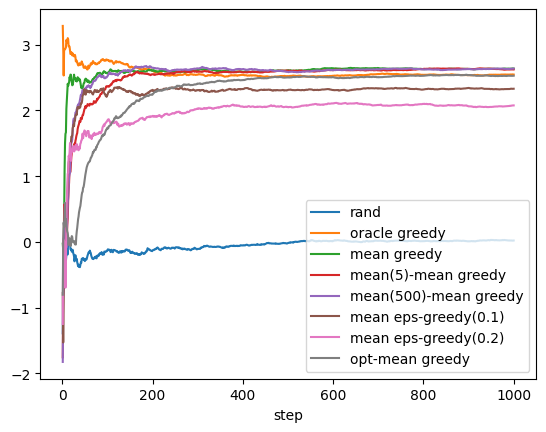

In [16]:
pd.DataFrame({
    'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["rewards"],
    'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
    'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["rewards"],
    'mean(5)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
    'mean(500)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=500), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
    'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["rewards"],
    'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["rewards"],
    'opt-mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["rewards"],
}).plot()

<Axes: xlabel='step'>

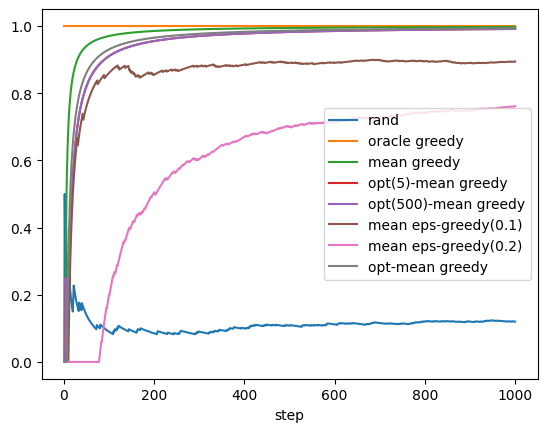

In [17]:
pd.DataFrame({
    'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=1000)["optimal"],
    'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
    'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=1000)["optimal"],
    'opt(5)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
    'opt(500)-mean greedy': simulate(env, RunningMeanEstimator(env, prior=500), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
    'mean eps-greedy(0.1)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.1), steps=1000)["optimal"],
    'mean eps-greedy(0.2)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.2), steps=1000)["optimal"],
    'opt-mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.0), steps=1000)["optimal"],
}).plot()

### Compare gready & eps-greedy strategies:

  0%|          | 0/2000 [00:00<?, ?it/s]

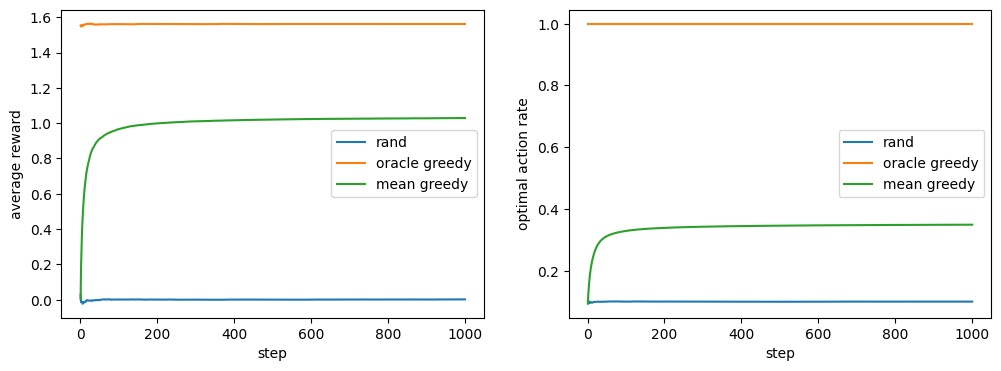

In [18]:
num_arms = 10
num_runs = 2000
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = MABEnv(num_actions=num_arms)
    run_result = {
        'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=num_steps),
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

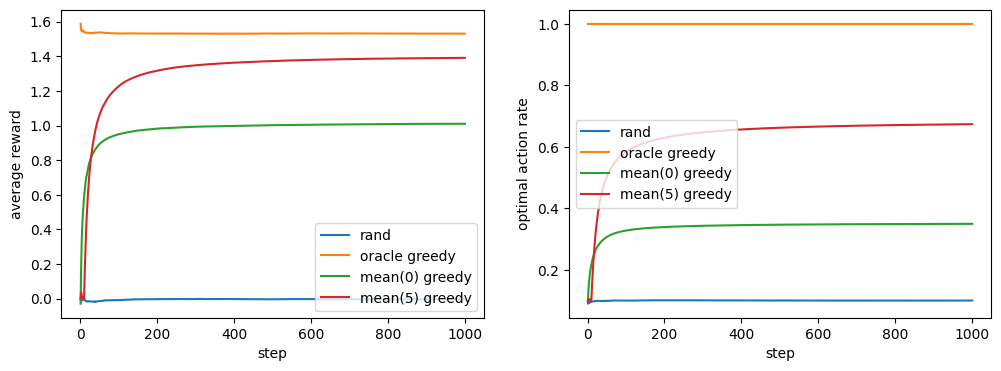

In [19]:
num_arms = 10
num_runs = 2000
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = MABEnv(num_actions=num_arms)
    run_result = {
        'rand': simulate(env, DummyEstimator(env), RandomSelectionRule(), steps=num_steps),
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(5) greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

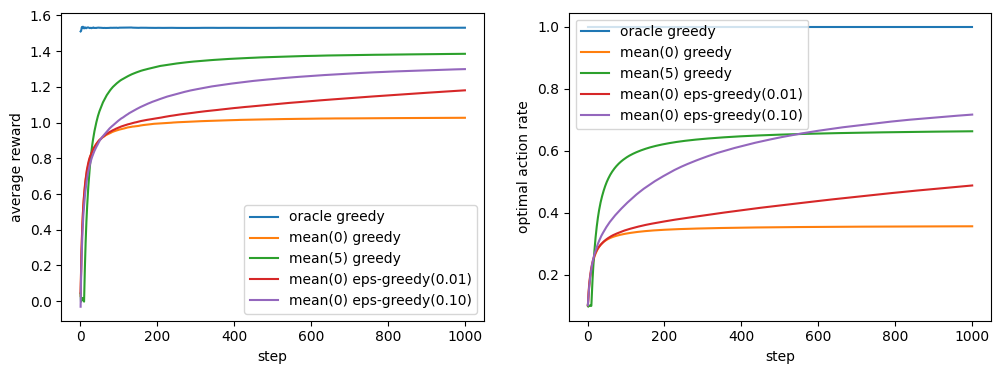

In [20]:
num_arms = 10
num_runs = 2000
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = MABEnv(num_actions=num_arms)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) greedy': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(5) greedy': simulate(env, RunningMeanEstimator(env, prior=5), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.01)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.01), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

### Excercise 2.5.

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation of 0.01 to all the $q_*(a)$ on each step).  

Prepare plots like Fiture 2.2 for an action-value method using sample averages, incrementally computed and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon=0.1$ and longer runs, say of 10,000 steps.

In [13]:
class NonStationaryMABEnv:
    def __init__(self, num_actions: int, reward_steps: int = 0, reward_mean = 1, reward_scale = 1):
        self.num_actions = num_actions
        self.reward_steps = reward_steps
        self.reward_scale = reward_scale
        self.actions = np.ndarray(num_actions)
        init_rewards = np.full(shape=(self.num_actions, 1), fill_value=reward_mean)
        random_walk = np.random.normal(loc=0, scale=0.01, size=(self.num_actions,self.reward_steps-1))
        self.rewards = np.concat([init_rewards, random_walk], axis=1).cumsum(axis=1)
        self.reset()
        
    def reset(self):
        self.timestep = 0

    def update(self):
        self.timestep += 1

    def get_timestep(self):
        return self.timestep

    def get_actions(self) -> np.ndarray:
        return self.actions

    def get_rewards(self) -> np.ndarray:
        return self.rewards[:, self.timestep]

    def get_reward_trajectories(self) -> np.ndarray:
        return self.rewards

    def perform_action(self, action_id: int, size=1) -> float:
        reward = self.rewards[action_id][self.timestep]
        reward = np.random.normal(loc=reward, scale=self.reward_scale, size=size)[0]
        return reward

In [22]:
env = NonStationaryMABEnv(num_actions=10, reward_steps=20000, reward_mean=4)

<Axes: >

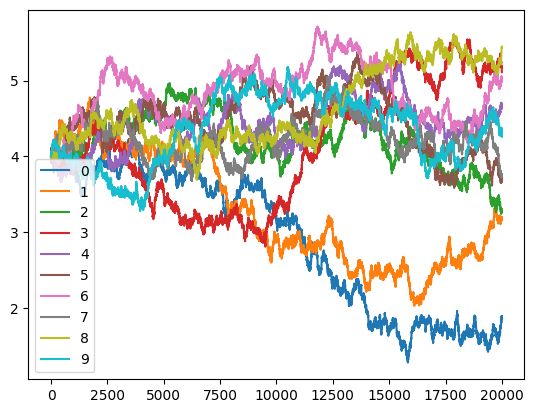

In [23]:
pd.DataFrame(env.rewards.T).plot()

#### Checking that we can replay same reward trajectories when simulating multiple models

  0%|          | 0/1 [00:00<?, ?it/s]

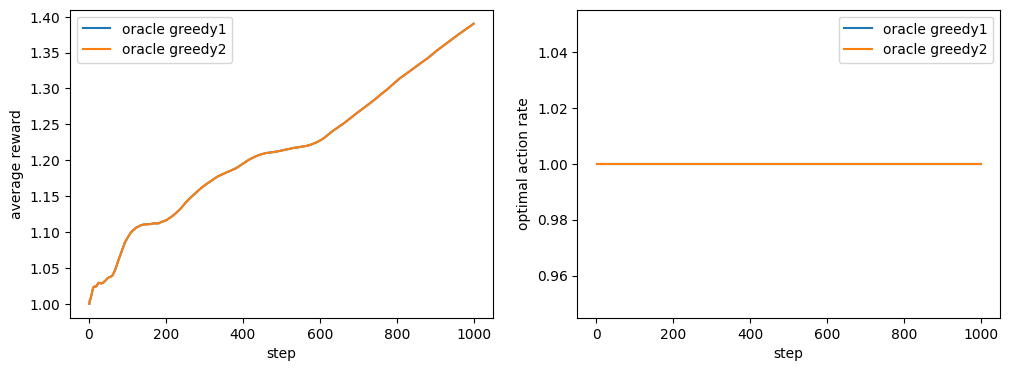

In [24]:
num_arms = 10
num_runs = 1
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps, reward_scale=0)
    run_result = {
        'oracle greedy1': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'oracle greedy2': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps)
    }
    run_results.append(run_result)

plot_results(run_results)

#### Test Epsilon-Greedy on a non-stationary problem:

  0%|          | 0/500 [00:00<?, ?it/s]

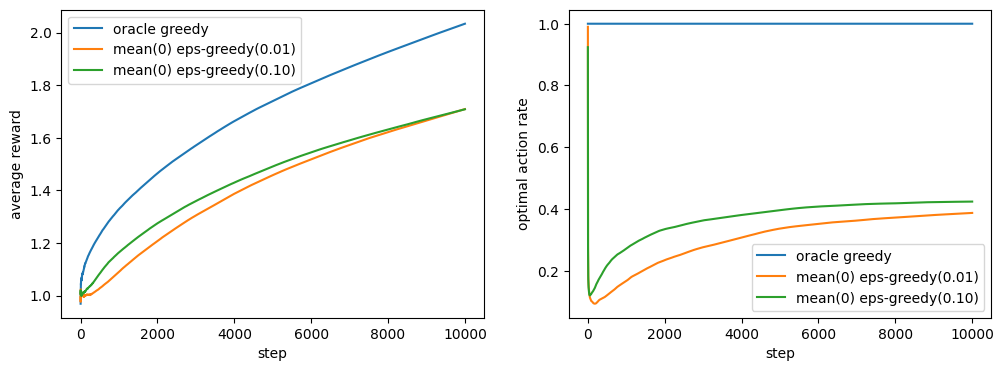

In [26]:
num_arms = 10
num_runs = 500
num_steps = 10000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.01)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.01), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

#### Coding a solution from (2.5) + unbiasing technique from (2.6)

/tmp/ipykernel_1948/3948141836.py:10: RuntimeWarning: divide by zero encountered in divide
  pd.DataFrame({'o': o_vals, 'alpha/o': alpha/o_vals}).plot()


<Axes: >

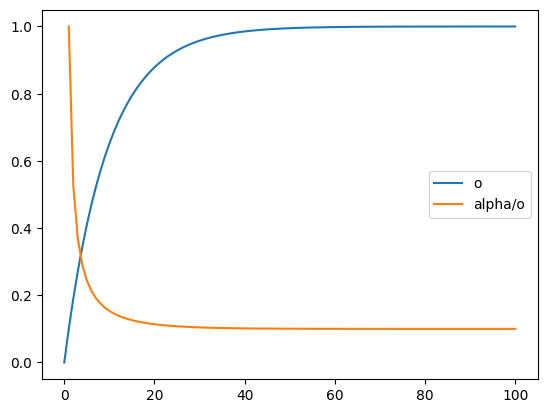

In [27]:
alpha = 0.1
o = 0
o_vals = [0]
for _ in range(100):
    o += alpha * (1 - o)
    o_vals.append(o)

o_vals = np.array(o_vals)

pd.DataFrame({'o': o_vals, 'alpha/o': alpha/o_vals}).plot()

In [14]:
class ExponentialRecencyWeightedAverageEstimator(BaseEstimator):
    def __init__(self, env, prior: float = 0, step = 0.1, unbiased: bool = False):
        self.env = env
        self.prior = prior
        self.step = step
        self.unbiased = unbiased
        self.reset()

    def reset(self):
        self.unbiasing_term = 0
        self.reward_counts = np.full_like(self.env.get_actions(), fill_value=0)
        self.reward_estimates = np.full_like(self.env.get_actions(), fill_value=self.prior)

    def learn_reward(self, action_id: int, reward: float) -> None:
        self.reward_counts[action_id] += 1
        if self.unbiased:
            self.unbiasing_term += self.step * (1 - self.unbiasing_term)
            step_size = self.step / self.unbiasing_term
        else:
            step_size = self.step
        self.reward_estimates[action_id] += step_size * (reward - self.reward_estimates[action_id])

    def get_rewards(self) -> np.ndarray:
        return self.reward_estimates
    
    def get_reward_counts(self) -> np.ndarray:
        return self.reward_counts

  0%|          | 0/500 [00:00<?, ?it/s]

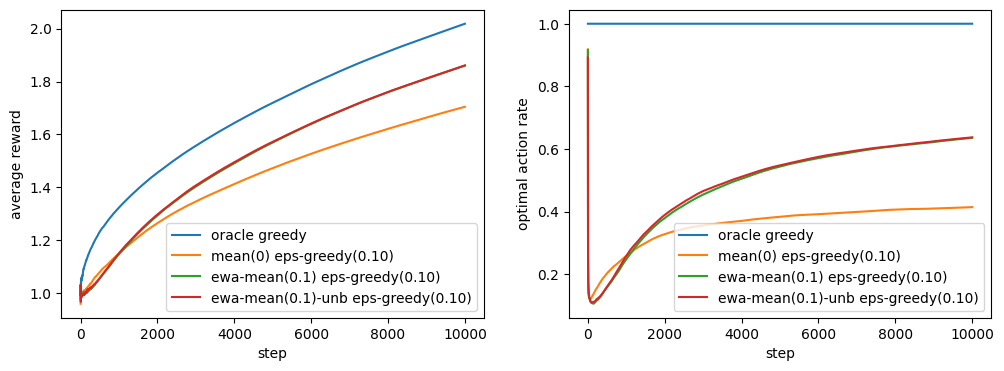

In [29]:
num_arms = 10
num_runs = 500
num_steps = 10000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'ewa-mean(0.1) eps-greedy(0.10)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'ewa-mean(0.1)-unb eps-greedy(0.10)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1, unbiased=True), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

### Implementing and testing UCB and Gradient Bandit Algos

In [15]:
class UCBSelectionRule:
    def __init__(self, coef: float = 0.5):
        self.coef = coef

    def pick_action(self, env, estimator):
        r = estimator.get_rewards()
        n = estimator.get_reward_counts()
        t = np.log(np.full_like(n, fill_value=1+env.get_timestep()))
        ucb = r + self.coef * np.sqrt(t/(n+1e-18))
        return ucb.argmax()

  0%|          | 0/500 [00:00<?, ?it/s]

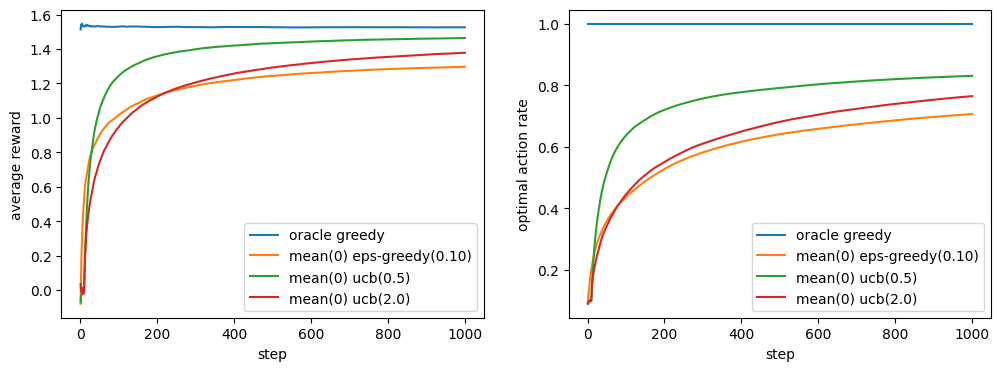

In [35]:
num_arms = 10
num_runs = 500
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = MABEnv(num_actions=num_arms)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'mean(0) ucb(0.5)': simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=0.50), steps=num_steps),
        'mean(0) ucb(2.0)': simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=2.00), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

UCB seems to beat Epsilon-Greedy on a stationary testbed, with UCB(0.5) being a clear winner

#### Comparing UCB vs $\epsilon$-greedy algo on a nonstationary problem:

  0%|          | 0/500 [00:00<?, ?it/s]

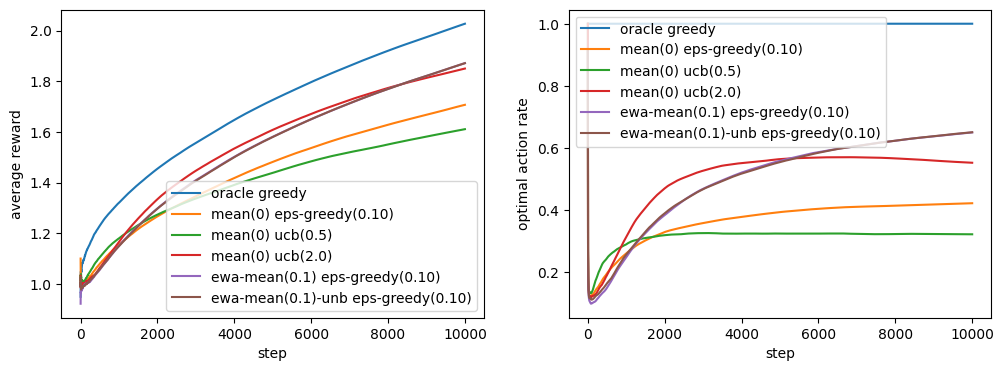

In [36]:
num_arms = 10
num_runs = 500
num_steps = 10000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'mean(0) ucb(0.5)': simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=0.50), steps=num_steps),
        'mean(0) ucb(2.0)': simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=2.00), steps=num_steps),
        'ewa-mean(0.1) eps-greedy(0.10)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'ewa-mean(0.1)-unb eps-greedy(0.10)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1, unbiased=True), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

For a non-stationary testbed both Epsilon-Greedy and UCB(0.5) are performing poorly.  
Interstingly, UCB(2.0) seems to get best performance in the first 5k steps, but then it gets surpassed by Weighted Mean + Epsilon-Greedy.

  0%|          | 0/500 [00:00<?, ?it/s]

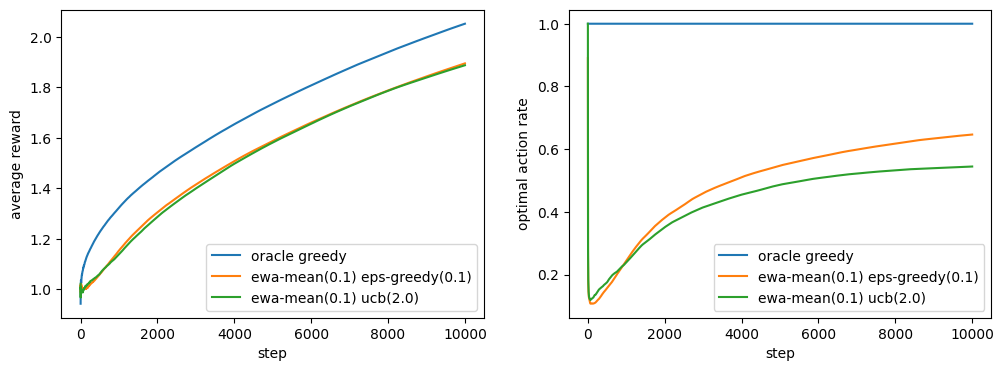

In [37]:
num_arms = 10
num_runs = 500
num_steps = 10000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'ewa-mean(0.1) eps-greedy(0.1)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'ewa-mean(0.1) ucb(2.0)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), UCBSelectionRule(coef=2.00), steps=num_steps)
    }
    run_results.append(run_result)

plot_results(run_results)

Combining Weighted Mean Estimator with UCB(2.0) selection rule doesn't seem to make much sense, as it doesn't seem to provide any improvement on top of epsilon-greedy selection rule.

#### Implement Gradient Bandit Algorithm

In [16]:
import typing as t

_DEBUG = False
_debug_baselines = []
_debug_probabilities = []
_debug_preferences = []
_debug_preferences_deltas = []
_debug_probabilities_deltas = []

def softmax(input):
    input = np.exp(input)
    norm = np.sum(input)
    probs = input / norm
    return probs

class GradientBanditEstimator(BaseEstimator):
    def __init__(self, env, step_size: float = 0.1, baseline: t.Union[float, BaseEstimator] = 0.0, initial_preference: float = 0.0):
        self.env = env
        self.step_size = step_size
        self.baseline = baseline
        self.initial_preference = initial_preference
        self.reset()

    def reset(self):
        if self.baseline and isinstance(self.baseline, BaseEstimator):
            self.baseline.reset()
        self.preferences = np.full_like(self.env.get_actions(), fill_value=self.initial_preference)
        self.probabilities = softmax(self.preferences)

    def get_reward_probs(self):
        return self.probabilities

    def learn_reward(self, action_id: int, reward: float) -> None:
        if isinstance(self.baseline, BaseEstimator):
            # HACK: we're re-using existing base estimators but always passing 
            # action_id=0 here as to calculate global average reward across all actions:
            # At first I used per-action estimates here, but it led to poor performance
            # https://ai.stackexchange.com/questions/35371/gradient-bandit-algorithm-is-barr-t-average-of-all-rewards-or-average-of-r
            reward_estimate = self.baseline.get_rewards()[0]
            self.baseline.learn_reward(0, reward)
        else:
            reward_estimate = self.baseline
        probs = self.get_reward_probs()
        flags = np.zeros_like(probs)
        flags[action_id] = 1
        reward_delta = (reward - reward_estimate) * (flags - probs)
        preferences_delta = self.step_size * reward_delta
        preferences_new = self.preferences + preferences_delta
        probabilities_new = softmax(preferences_new)
        probabilities_delta = (probabilities_new - self.probabilities) # for debug purposes
        self.preferences = preferences_new
        self.probabilities = probabilities_new
        
        ## DEBUG:
        if _DEBUG:
            _debug_baselines.append(reward_estimate)
            _debug_probabilities.append(self.probabilities)
            _debug_preferences.append(self.preferences)
            _debug_preferences_deltas.append(preferences_delta)
            _debug_probabilities_deltas.append(probabilities_delta)

    # def get_rewards(self) -> np.ndarray:
    #     return self.baseline.get_rewards()

    # def get_reward_counts(self) -> np.ndarray:
    #     return self.baseline.get_rewards_count()

In [17]:
class GradientBanditSelectionRule:
    def pick_action(self, env, estimator):
        probs = estimator.get_reward_probs()
        return np.random.choice(a=len(probs), size=1, p=probs)[0]

#### Debugging update steps:

In [22]:
num_arms = 10
num_runs = 500
num_steps = 1000
env = MABEnv(num_actions=num_arms, reward_mean=4, reward_scale=5)
print(env.get_rewards())

_DEBUG = True
_debug_baselines = []
_debug_probabilities = []
_debug_preferences = []
_debug_preferences_deltas = []
_debug_probabilities_deltas = []

simulate(
    env=env, 
    estimator=GradientBanditEstimator(env, step_size=0.1, baseline=RunningMeanEstimator(env), initial_preference=0), 
    rule=GradientBanditSelectionRule(), 
    steps=num_steps
)

_DEBUG = False

[ 1.14420766 -0.87413258  4.97993798  2.55417823 -1.23379603 -3.25200596
  4.32226843 10.85091757 -2.87750409  4.60704508]


<Axes: >

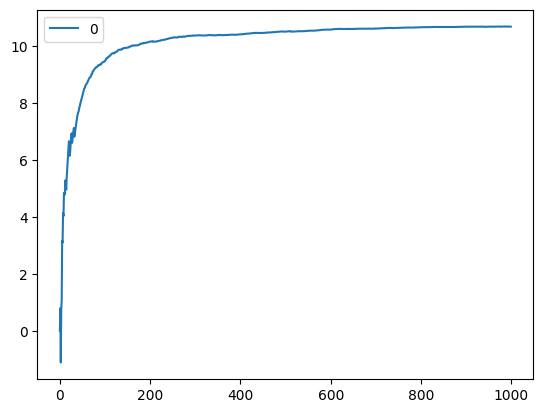

In [23]:
pd.DataFrame(np.stack(_debug_baselines)).plot()

<Axes: >

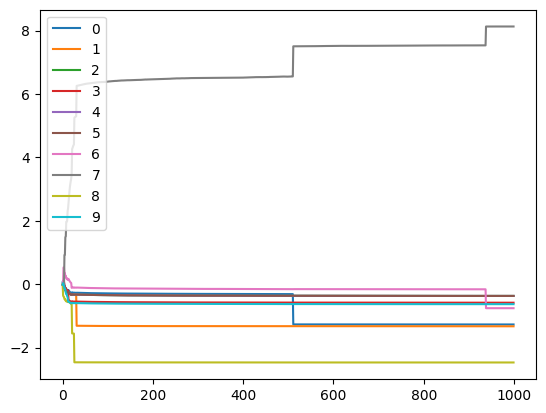

In [24]:
pd.DataFrame(np.stack(_debug_preferences)).plot()

<Axes: >

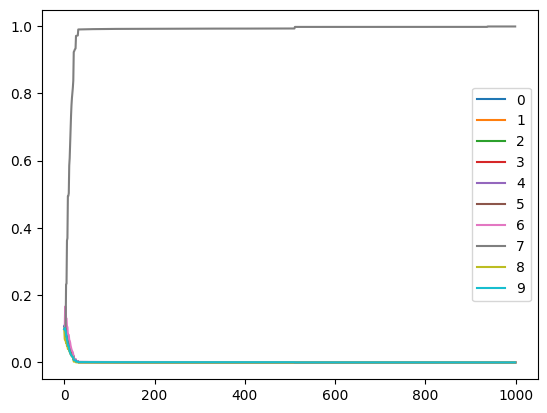

In [25]:
pd.DataFrame(np.stack(_debug_probabilities)).plot()

<Axes: >

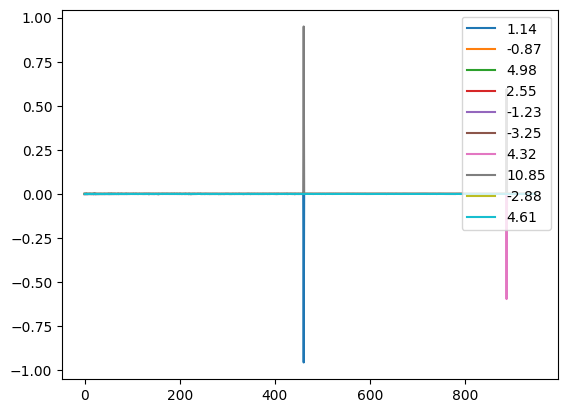

In [26]:
pd.DataFrame(np.stack(_debug_preferences_deltas)[50:], columns=[f"{c:0.2f}" for c in env.get_rewards()]).plot()

<Axes: >

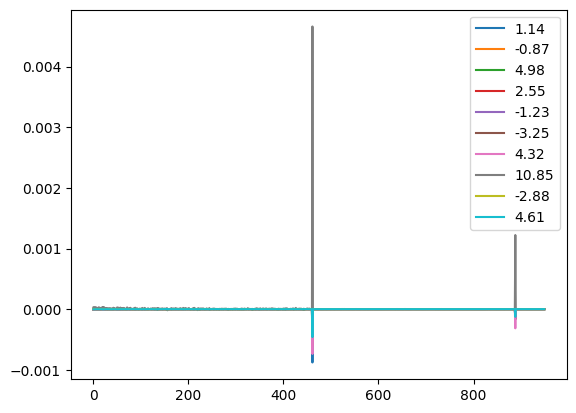

In [27]:
pd.DataFrame(np.stack(_debug_probabilities_deltas)[50:], columns=[f"{c:0.2f}" for c in env.get_rewards()]).plot()

#### Comparison of Gradient Bandit Algorithms with and without a reward baseline (on 0-cenetered rewards):

  0%|          | 0/500 [00:00<?, ?it/s]

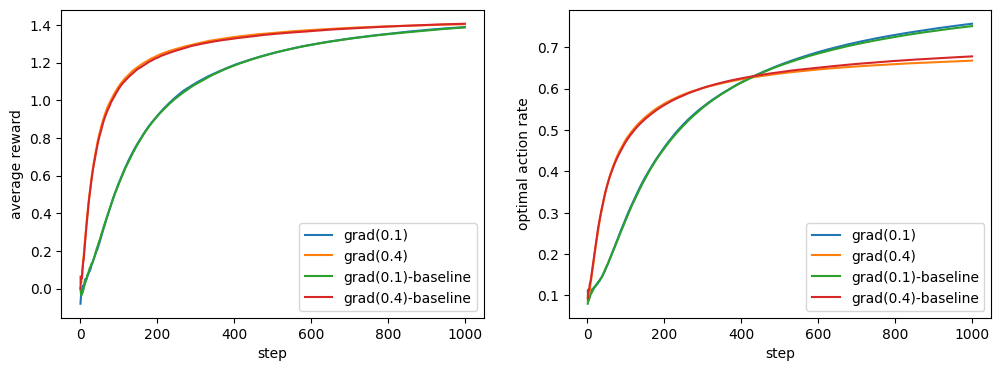

In [28]:
num_arms = 10
num_runs = 500
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = MABEnv(num_actions=num_arms, reward_mean=0)
    run_result = {
        # 'mean(0) eps-greedy(0.10)': simulate(env, RunningMeanEstimator(env), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'grad(0.1)': simulate(env, GradientBanditEstimator(env, step_size=0.1), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.4)': simulate(env, GradientBanditEstimator(env, step_size=0.4), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.1)-baseline': simulate(env, GradientBanditEstimator(env, step_size=0.1, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.4)-baseline': simulate(env, GradientBanditEstimator(env, step_size=0.4, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

Baseline doesn't seem to add much in the case of zero-centered rewards

#### Comparison of Gradient Bandit Algorithms with and without a reward baseline on rewards cenetered at +4 (Figure 2.5)

  0%|          | 0/500 [00:00<?, ?it/s]

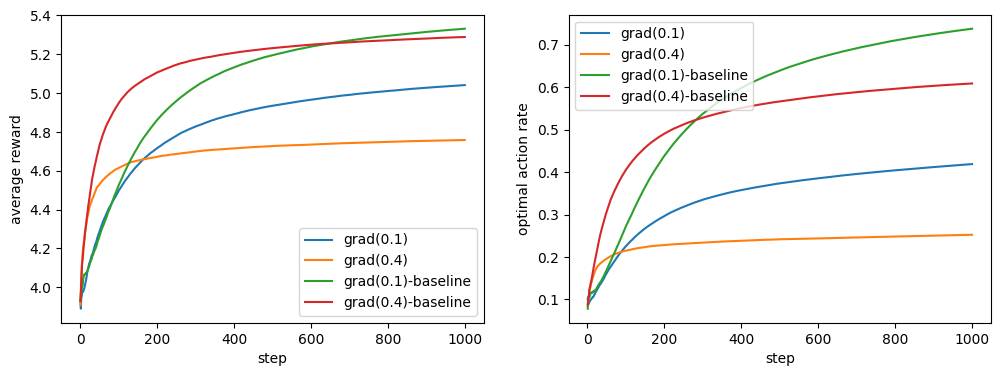

In [29]:
num_arms = 10
num_runs = 500
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = MABEnv(num_actions=num_arms, reward_mean=4)
    run_result = {
        'grad(0.1)': simulate(env, GradientBanditEstimator(env, step_size=0.1), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.4)': simulate(env, GradientBanditEstimator(env, step_size=0.4), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.1)-baseline': simulate(env, GradientBanditEstimator(env, step_size=0.1, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.4)-baseline': simulate(env, GradientBanditEstimator(env, step_size=0.4, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

However, when rewards are centered at some value far from 0, baseline does help improve performance

#### Comparing different versions of Gradient Bandit algo on a nonstationary problem:

  0%|          | 0/500 [00:00<?, ?it/s]

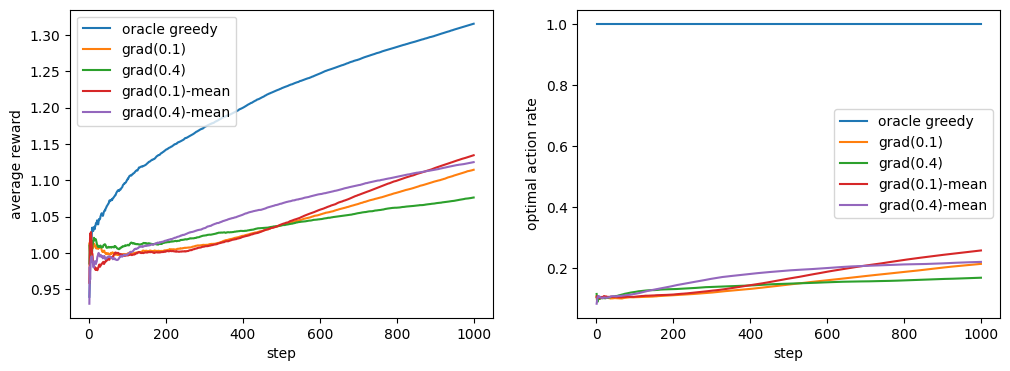

In [30]:
num_arms = 10
num_runs = 500
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'grad(0.1)': simulate(env, GradientBanditEstimator(env, step_size=0.1), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.4)': simulate(env, GradientBanditEstimator(env, step_size=0.4), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.1)-mean': simulate(env, GradientBanditEstimator(env, step_size=0.1, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.4)-mean': simulate(env, GradientBanditEstimator(env, step_size=0.4, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

Gradient Bandits with Running Mean Estimator are not very good for nonstationary case

  0%|          | 0/500 [00:00<?, ?it/s]

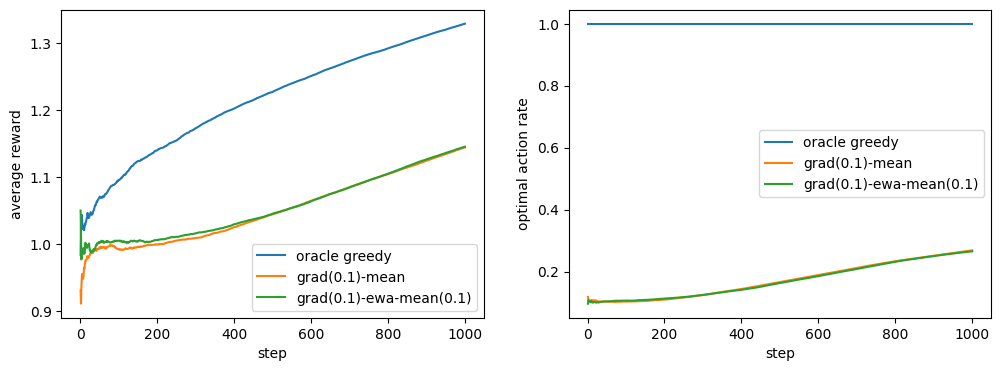

In [31]:
num_arms = 10
num_runs = 500
num_steps = 1000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'grad(0.1)-mean': simulate(env, GradientBanditEstimator(env, step_size=0.1, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.1)-ewa-mean(0.1)': simulate(env, GradientBanditEstimator(env, step_size=0.1, baseline=ExponentialRecencyWeightedAverageEstimator(env, step=0.1)), GradientBanditSelectionRule(), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

  0%|          | 0/100 [00:00<?, ?it/s]

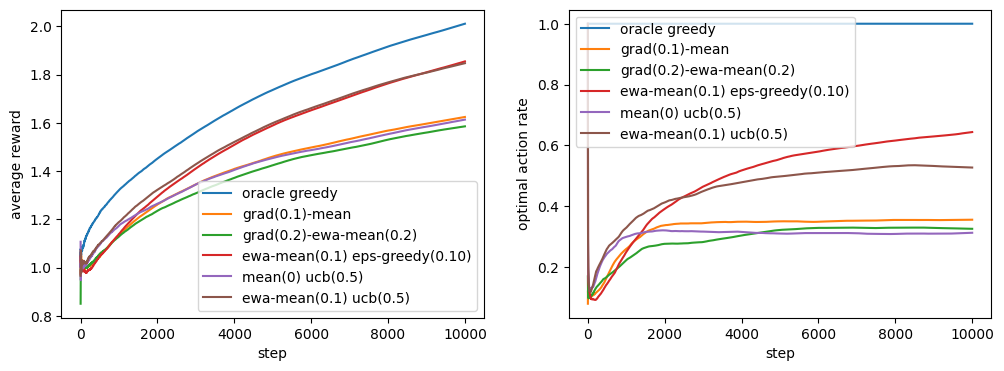

In [35]:
num_arms = 10
num_runs = 100
num_steps = 10000

run_results = []
for run_id in tqdm.trange(num_runs):
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=num_steps)
    run_result = {
        'oracle greedy': simulate(env, OracleEstimator(env), EpsilonGreedySelectionRule(eps=0), steps=num_steps),
        'grad(0.1)-mean': simulate(env, GradientBanditEstimator(env, step_size=0.1, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps),
        'grad(0.2)-ewa-mean(0.2)': simulate(env, GradientBanditEstimator(env, step_size=0.2, baseline=ExponentialRecencyWeightedAverageEstimator(env, step=0.2)), GradientBanditSelectionRule(), steps=num_steps),
        'ewa-mean(0.1) eps-greedy(0.10)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), EpsilonGreedySelectionRule(eps=0.10), steps=num_steps),
        'mean(0) ucb(0.5)': simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=0.50), steps=num_steps),
        'ewa-mean(0.1) ucb(0.5)': simulate(env, ExponentialRecencyWeightedAverageEstimator(env, step=0.1), UCBSelectionRule(coef=0.50), steps=num_steps),
    }
    run_results.append(run_result)

plot_results(run_results)

### Excercise 2.11

Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Excercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with $\alpha=0.1$.  
Use runs of 200,000 steps and, as a performmeasure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.

#### Reproducing Figure 2.6:

In [85]:
def param_to_str(x):
    return f'{x}' if x >= 1 else f'1/{1/x:.0f}'

def summarize_results(sim_results, sim_name, param, eval_from = None, eval_to = None):
    return {
        'name': sim_name, 
        'param': param_to_str(param), 
        'reward': sim_results["rewards"][eval_from:eval_to].mean(), 
        'accuracy': sim_results["optimal"][eval_from:eval_to].mean()
    }

def plot_summary(run_results):
    avg_results = results.groupby(by=["param", "name"]).mean().reset_index().set_index('param')
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    avg_results.groupby(by="name")["reward"].plot(ylabel="average reward", ax = axes[0], legend=True)
    avg_results.groupby(by="name")["accuracy"].plot(ylabel="optimal action rate", ax = axes[1], legend=True)

  0%|          | 0/500 [00:00<?, ?it/s]

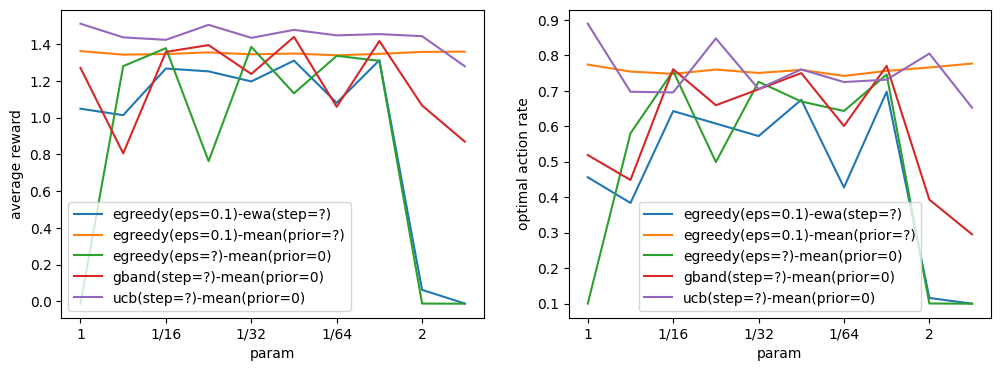

In [94]:
num_arms = 10
num_runs = 500
num_steps = 5000
res_idx_from = 0
res_idx_to = None

results = []
param_space = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

for run_id in tqdm.trange(num_runs):

    env = MABEnv(num_actions=num_arms)

    for param in param_space:
        sim_name = f'egreedy(eps=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=0), EpsilonGreedySelectionRule(eps=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'egreedy(eps=0.1)-mean(prior=?)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'egreedy(eps=0.1)-ewa(step=?)'
        sim_result = simulate(env, ExponentialRecencyWeightedAverageEstimator(env, prior=0, step=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'gband(step=?)-mean(prior=0)'
        sim_result = simulate(env, GradientBanditEstimator(env, step_size=param, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'ucb(step=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

results = pd.DataFrame(results)
plot_summary(results)

#### Repeating same algos on stationary problems but simulating 200k steps & reporting perf on last 100k

  0%|          | 0/5 [00:00<?, ?it/s]

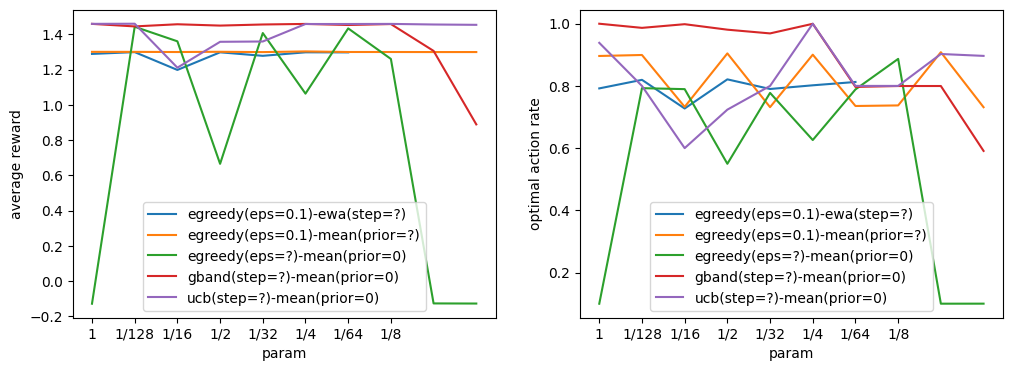

In [95]:
num_arms = 10
num_runs = 5
num_steps = 200_000
res_idx_from = 100_000
res_idx_to = None

results = []
param_space = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

for run_id in tqdm.trange(num_runs):

    env = MABEnv(num_actions=num_arms)

    for param in param_space:
        sim_name = f'egreedy(eps=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=0), EpsilonGreedySelectionRule(eps=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'egreedy(eps=0.1)-mean(prior=?)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space[:-3]:
        sim_name = f'egreedy(eps=0.1)-ewa(step=?)'
        sim_result = simulate(env, ExponentialRecencyWeightedAverageEstimator(env, prior=0, step=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'gband(step=?)-mean(prior=0)'
        sim_result = simulate(env, GradientBanditEstimator(env, step_size=param, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'ucb(step=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

results = pd.DataFrame(results)
plot_summary(results)

#### Repeating same tests on nonstationary data:

  0%|          | 0/5 [00:00<?, ?it/s]

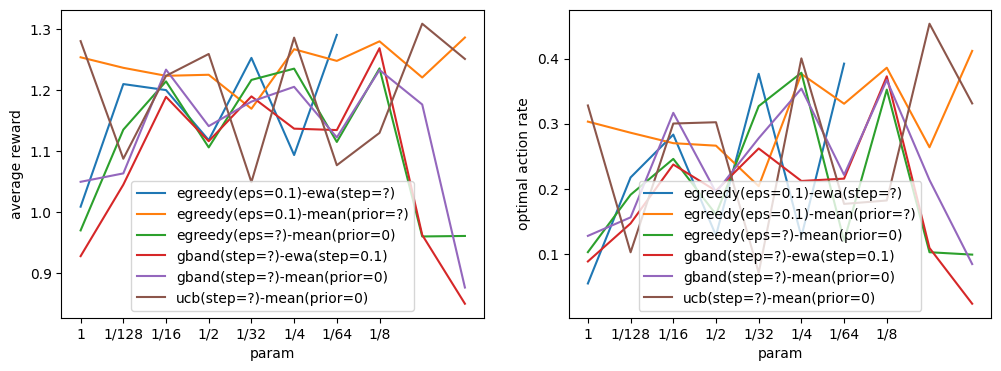

In [97]:
num_arms = 10
num_runs = 5
num_steps = 5000
res_idx_from = 0
res_idx_to = None

results = []
param_space = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

for run_id in tqdm.trange(num_runs):
    
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=200_000)

    for param in param_space:
        sim_name = f'egreedy(eps=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=0), EpsilonGreedySelectionRule(eps=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'egreedy(eps=0.1)-mean(prior=?)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space[:-3]:
        sim_name = f'egreedy(eps=0.1)-ewa(step=?)'
        sim_result = simulate(env, ExponentialRecencyWeightedAverageEstimator(env, prior=0, step=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'gband(step=?)-mean(prior=0)'
        sim_result = simulate(env, GradientBanditEstimator(env, step_size=param, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

    for param in param_space:
        sim_name = f'gband(step=?)-ewa(step=0.1)'
        sim_result = simulate(env, GradientBanditEstimator(env, step_size=param, baseline=ExponentialRecencyWeightedAverageEstimator(env)), GradientBanditSelectionRule(), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

    for param in param_space:
        sim_name = f'ucb(step=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param, res_idx_from, res_idx_to))

results = pd.DataFrame(results)
plot_summary(results)

  0%|          | 0/5 [00:00<?, ?it/s]

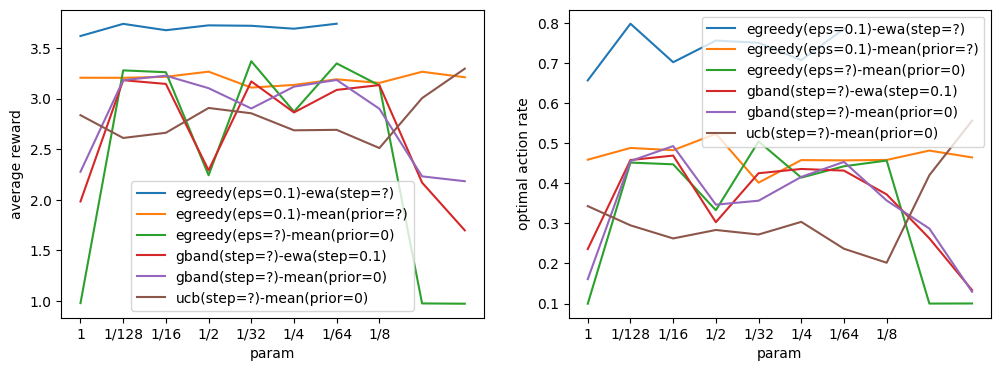

In [98]:
num_arms = 10
num_runs = 5
num_steps = 200_000
res_idx_from = 100_000
res_idx_to = None

results = []
param_space = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]

for run_id in tqdm.trange(num_runs):
    
    env = NonStationaryMABEnv(num_actions=num_arms, reward_steps=200_000)

    for param in param_space:
        sim_name = f'egreedy(eps=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=0), EpsilonGreedySelectionRule(eps=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

    for param in param_space:
        sim_name = f'egreedy(eps=0.1)-mean(prior=?)'
        sim_result = simulate(env, RunningMeanEstimator(env, prior=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

    for param in param_space[:-3]:
        sim_name = f'egreedy(eps=0.1)-ewa(step=?)'
        sim_result = simulate(env, ExponentialRecencyWeightedAverageEstimator(env, prior=0, step=param), EpsilonGreedySelectionRule(eps=0.1), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

    for param in param_space:
        sim_name = f'gband(step=?)-mean(prior=0)'
        sim_result = simulate(env, GradientBanditEstimator(env, step_size=param, baseline=RunningMeanEstimator(env)), GradientBanditSelectionRule(), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

    for param in param_space:
        sim_name = f'gband(step=?)-ewa(step=0.1)'
        sim_result = simulate(env, GradientBanditEstimator(env, step_size=param, baseline=ExponentialRecencyWeightedAverageEstimator(env)), GradientBanditSelectionRule(), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

    for param in param_space:
        sim_name = f'ucb(step=?)-mean(prior=0)'
        sim_result = simulate(env, RunningMeanEstimator(env), UCBSelectionRule(coef=param), steps=num_steps)
        results.append(summarize_results(sim_result, sim_name, param))

results = pd.DataFrame(results)
plot_summary(results)